<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br><b>Image Display and Manipulation</b> <br>
Contact authors: Alex Drlica-Wagner, Jeff Carlin <br>
Last verified to run: 2024-05-01 <br>
LSST Science Pipelines version: Weekly 2024_16 <br>
Container Size: medium <br>
Targeted learning level: beginner <br>

**Description:** Learn to display and manipulate images using the LSST Science Pipelines.

**Skills:** Display and manipulate images, explore image mask planes, create cutouts and RGB images.

**LSST Data Products:** Butler calexp and deepCoadd images, coadd objectTable

**Packages:** lsst.afw.display, lsst.daf.butler, lsst.geom, lsst.afw.image

**Credit:** This tutorial is based on the [`AFW_Display_Demo.ipynb`](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Visualization/AFW_Display_Demo.ipynb) notebook originally written by Brant Robertson and maintained by the LSST Stack Club.

More examples of the use of `lsst.afw.display` can be found in the [LSST Science Pipelines documentation](https://pipelines.lsst.io/getting-started/display.html).

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>.
Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This tutorial is designed to help users get a brief feel for the `lsst.afw.display` library that enables the visual inspection of image data. The [`lsst.afw` library](https://github.com/lsst/afw) provides an "Astronomical Framework" (afw) while the `lsst.daf.*` libraries (see, e.g., [daf_base](https://github.com/lsst/daf_base)) provide a "Data Access Framework" (daf). Both libraries are used in this tutorial, with the `lsst.daf.butler` library used to access image data and the `lsst.afw.display` library used to show the exposure image on the screen using the matplotlib backend.

### 1.1. Package imports

Below, the `matplotlib.pyplot` sublibrary is imported for plotting, and the [`astropy.wcs`](https://docs.astropy.org/en/stable/wcs/index.html) package is imported for dealing with World Coordinate Systems (WCS).
The [`matplotlib`](https://matplotlib.org/) and [`astropy`](http://www.astropy.org/) libraries are widely used Python libraries for plotting, scientific computing, and astronomical data analysis.
The `gc` (garbage collector) package is imported to help clear the memory of large plots.

The `lsst.afw.display` and `lsst.afw.image` modules are loaded to gain access to the image visualization routines we'd like to use, and the `lsst.daf.butler` and `lsst.rsp.get_tap_service` modules are used to access data products.
The `lsst.geom` package is used for dealing with sky coordinates.

In [1]:
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb
import gc

import lsst.afw.display as afwDisplay
from lsst.afw.image import MultibandExposure
from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service
import lsst.geom as geom

from lsst.afw.image import Exposure, ExposureF


### 1.2. Define functions and parameters

#### 1.2.1. Functions

Matplotlib stores the data array associated with an image that is plotted. Since the LSST Charge-Coupled Device (CCD) detector images are large (~4k x 4k pixels), this can eventually lead to a memory overflow, which will cause the notebook kernel to die. To mitigate this issue, we define a function to clean up after we plot them.

In [2]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

<a id="cutout_coadd"></a>

Next we define a function to produce a cutout image from a coadd at the user-provided ra, dec.

In [3]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

The following function makes cutouts from `calexp` images instead of `deepCoadd` images.

In [4]:
def cutout_calexp(butler, ra, dec, visit, detector, cutoutSideLength=51, **kwargs):
    
    """
    Produce a cutout from a calexp at the given ra, dec position.

    Adapted from cutout_coadd which was adapted from a DC2 tutorial
    notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    visit: int
        Visit id of the calexp's visit
    detector: int
        Detector for the calexp
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    
    dataId = {'visit': visit, 'detector': detector}    
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)    
    calexp_wcs = butler.get('calexp.wcs', **dataId)
    xy = geom.PointI(calexp_wcs.skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    parameters = {'bbox': bbox}
    cutout_image = butler.get('calexp', parameters=parameters, **dataId)

    return cutout_image

#### 1.2.2. Paramters

Let `afwDisplay` know that we want it to use `matplotlib` as our default display backend by setting the `setDefaultBackend()` function.

Remember that we made an alias to `lsst.afw.display` called `afwDisplay`, so we'll use that to call `setDefaultBackend()`.

In [6]:
afwDisplay.setDefaultBackend('matplotlib')

Set the parameters of `matplotlib.pyplot` to give us a large default size for an image, and set some other parameters to make the default plot style be color-blind friendly and otherwise make plots look nice.

In [7]:
plt.style.use('tableau-colorblind10')
%matplotlib inline

In [8]:
params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [8, 8],
          'figure.facecolor': 'White'
          }
plt.rcParams.update(params)

## Section 0: Intro to Image Data (exerpt of tutorial notebook 1)

The two most common types of images that DP0 delegates will interact with are calexps and deepCoadds.

calexp: A single image in a single filter.

deepCoadd: A combination of single images into a deep stack or Coadd.

The LSST Science Pipelines processes and stores images in tracts and patches.

tract: A portion of sky within the LSST all-sky tessellation (sky map); divided into patches.

patch: A quadrilateral sub-region of a tract, of a size that fits easily into memory on desktop computers.

<img src="figures/dp02_patch_tract.png" width="700">



To retrieve and display an image at a desired coordinate, users have to specify their image type, tract, and patch.

## 0.1. Create an instance of the butler

The butler (documentation) is an LSST Science Pipelines software package to fetch LSST data without having to know its location or format. The butler can also be used to explore and discover what data exist. Other tutorials demonstrate the full butler functionality.

Create an instance of the butler using the following DP0.2 configuration and collection.
It will return an informative statement about credentials being found.

In [9]:
#butler = dafButler.Butler('dp02', collections='2.2i/runs/DP0.2')
butler = Butler('dp02', collections='2.2i/runs/DP0.2')

### 0.2. Identify and retrieve a deepCoadd
There is a cool-looking DC2 galaxy cluster at RA = 03h42m59.0s, Dec = -32d16m09s (in degrees, 55.745834, -32.269167).

Use lsst.geom to define a SpherePoint for the cluster's coordinates (<a href="https://pipelines.lsst.io/modules/lsst.geom/index.html">lsst.geom documentation</a>).


In [10]:
my_ra_deg = 55.745834
my_dec_deg = -32.269167

my_spherePoint = geom.SpherePoint(my_ra_deg*geom.degrees,
                                       my_dec_deg*geom.degrees)
print(my_spherePoint)

(55.7458340000, -32.2691670000)


Retrieve the DC2 sky map from the butler and use it to identify the tract and patch for the cluster's coordinates (<a href="http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/skymap.html">skymap documentation</a>).

In [11]:
skymap = butler.get('skyMap')

tract = skymap.findTract(my_spherePoint)
patch = tract.findPatch(my_spherePoint)

my_tract = tract.tract_id
my_patch = patch.getSequentialIndex()

print('my_tract: ', my_tract)
print('my_patch: ', my_patch)

my_tract:  4431
my_patch:  17


Use the butler to retrieve the deep i-band Coadd for the tract and patch.

In [12]:
dataId = {'band': 'i', 'tract': my_tract, 'patch': my_patch}
my_deepCoadd = butler.get('deepCoadd', dataId=dataId)

### 0.3. Display the image with afwDisplay
Image data retrieved with the butler can be displayed several different ways. A simple option is to use the LSST Science Pipelines package afwDisplay. There is some <a href="https://pipelines.lsst.io/modules/lsst.afw.display/index.html">documentation for afwDisplay</a> available, and other DP0 tutorials go into more detail about all the display options (e.g., overlaying mask data to show bad pixels).

Set the backend of afwDisplay to matplotlib.

In [13]:
afwDisplay.setDefaultBackend('matplotlib')

Use afwDisplay to show the image data retrieved.

The following code cell creates a matplotlib.pyplot figure; aliases `lsst.afw.display.Display` as `afw_display`; 
sets the scale for the pixel shading; displays the image data using `mtv`; and turns on the x and y axes labels (pixel coordinates).

(11899.5, 16099.5, 7899.5, 12099.5)

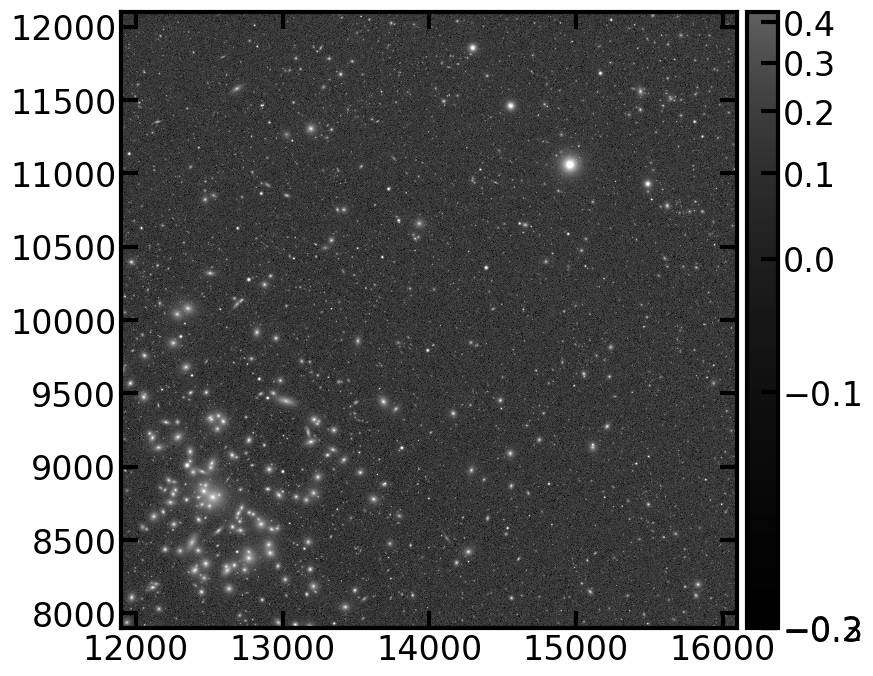

In [14]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_deepCoadd.image)
plt.gca().axis('on')

To learn more about the afwDisplay package and its tasks, use the help function.

In [15]:
# help(afw_display.scale)
# help(afw_display.mtv)

In [16]:
#afwDisplay.setDefaultBackend('firefly')
#afw_display = afwDisplay.Display(frame=1)
#afw_display.mtv(my_deepCoadd.image)

In [20]:
import sys
sys.exit()

SystemExit: 

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Now back to tutorial 3a:
## 2. Load the data to visualize (now some redundant with exerpt from tutorial notebook 1 above)

To display an image, we must first load some data. The DP0.2 data set contains simulated images from the LSST DESC Data Challenge 2 (DC2) that have been reprocessed by the LSST Project using a more recent version of the LSST Science Pipelines. To access these data, we instantiate a Butler directing it to the `dp02` data repository configuration and the `2.2i/runs/DP0.2` collection.  For more information on the `Butler`, see [lsst.daf.butler](https://pipelines.lsst.io/modules/lsst.daf.butler/index.html) and subsequent tutorials in this series.

In [ ]:
butler = Butler('dp02', collections='2.2i/runs/DP0.2')

With a `Butler` instance generated, we can retrieve the desired calibrated exposure by telling the butler which visit and CCD ("detector") we wish to view. To do this, we define a dictionary with the required information. In this case, we access a single image from a specific visit (`192350`) and detector (`175`).

In [ ]:
dataId = {'visit': 192350, 'detector': 175, 'band': 'i'}

In [ ]:
calexp = butler.get('calexp', **dataId)

The `calexp` that is returned by the Butler in the previous cell is an `ExposureF` Python object. Exposures are powerful representations of image data because they contain not only the image data, but also a variance image for uncertainty propagation, a bit mask image, and key-value metadata. In the next section, we will use AFWDisplay to visualize the image and mask associated with this Exposure. More documentation on accessing and visualizing an Exposure be found [here](https://pipelines.lsst.io/getting-started/display.html).

## 3. Basic image visualization

### 3.1. Use AFWDisplay to visualize the image

We are now set to display the image. To do this, we:

1. Create a `matplotlib.pyplot` figure using `plt.figure()` -- this will be familiar to anyone with experience using `matplotlib`.
2. Create an alias to the `lsst.afw.display.Display` method that will allow us to display the data to the screen.  This alias will be called `display`.
3. Before showing the data on the screen, we have to decide how to apply an image stretch given the data. The algorithm we'll use is `asinh` -- familiar from SDSS images -- with a range of values set by `zscale`. To do this, we use the `scale()` function provided by `lsst.afw.display`. See the `scale()` function definition in the [`interface.py` file of the lsst.afw.display library](https://github.com/lsst/afw/blob/master/python/lsst/afw/display/interface.py).
4. Finally, we can display the image. To do this, we provide the `mtv()` method the `calexp.image` member of our calibrated image retrieved by the `butler`. We can then use `plt.show()` to display our figure.
5. After we are done creating and displaying the image, we remove the underlying data from memory.

All these tasks are best done within the same notebook cell.

In [ ]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(calexp.image)
plt.show()
remove_figure(fig)

To see the image axes in sky coordinates instead of pixel coordinates, a simple option is to use astropy's World Coordinate System (WCS) package, along with matplotlib.pyplot's `subplot`, `imshow`, and `grid` functions. 
Recall that we imported `matplotlib.pyplot` as `plt` already, and that we imported the `astropy.wcs.WCS` constructor as simply `WCS`.
Find more information about [imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) and [colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) (`cmap`).

To do this, we:
1. Set the figure's projection to be the WCS of the `calexp`.
2. Define the extent in pixel coordinates using the bounding box.
3. Display the calexp image data array using the gray colormap (cmap) and use approximately the same min and max scale values as above.
4. Add solid white grid lines.
5. Label the axes, and show the plot.
6. Remove the underlying data from memory.

In [ ]:
fig = plt.figure()
plt.subplot(projection=WCS(calexp.getWcs().getFitsMetadata()))
calexp_extent = (calexp.getBBox().beginX, calexp.getBBox().endX,
                 calexp.getBBox().beginY, calexp.getBBox().endY)
im = plt.imshow(calexp.image.array, cmap='gray', vmin=-200.0, vmax=400,
                extent=calexp_extent, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.show()
remove_figure(fig)

**Congratulations!** We've plotted an image in various ways using `lsst.afw.display`!

### 3.2. Use afwDisplay to visualize the image and mask plane

The `calexp` returned by the butler contains more than just the image pixel values (see the Stack Club [calexp tutorial](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Basics/Calexp_guided_tour.ipynb) for more details). 
One other component is the mask associated with the image. 
A mask is composed of a set of "mask planes," 2D binary bit maps corresponding to pixels that are masked for various reasons (see [here](https://pipelines.lsst.io/v/DM-11392/getting-started/display.html#interpreting-displayed-mask-colors) for more details).

The `afwDisplay` package maps each bit in the mask plane to a specific display color. 
We can view this mapping using the code in the following cell. 
We can also use the `setMaskPlaneColor` method to change the colors that `afwDisplay` uses for each mask plane.

Print the colors associated to each plane in the mask.

In [ ]:
print("Mask plane bit definitions:\n", display.getMaskPlaneColor())
print("\nMask plane methods:\n")
help(display.setMaskPlaneColor)

Let's plot the image and mask plane side-by-side using matplotlib subplots.

Use `plt.sca(ax[0])` to set the first axis as current, and then `plt.sca(ax[1])` to switch to the second axis.
Using `plt.tight_layout()` with multi-axis figures helps to avoid axis overlap or excessive white spaces and results in a nicer-looking plot.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
plt.sca(ax[0])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(calexp.image)
plt.sca(ax[1])
display2 = afwDisplay.Display(frame=fig)
display2.mtv(calexp.mask)
plt.tight_layout()
plt.show()
remove_figure(fig)

The `afwDisplay` package also provides a nice interface for plotting the mask on top of the image using the `calexp.maskedImage`. 
The mask will also be plotted on top of the image if you pass the `calexp` itself to `mtv` (as is done later in this notebook).

In [ ]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('linear', 'zscale')
display.mtv(calexp.maskedImage)
plt.show()
remove_figure(fig)

To investigate the mask in a bit more detail, we'll follow the same steps as above to display the image, but we'll add a few modifications

1. We explicitly set the transparency of the overplotted mask
   (as a percentage: 0 = opaque, 100 = transparent)
2. We explicitly set the color of the 'DETECTED' mask plane to 'blue' (i.e., all pixels associated with detected objects).
3. We pass the full `calexp` object to `mtv` instead of just the image plane.

In [ ]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.setMaskTransparency(80)
display.setMaskPlaneColor('DETECTED', 'blue')
display.mtv(calexp)
plt.show()
remove_figure(fig)

### 3.3. More information about `lsst.afw.display`

To find more information about `lsst.afw.display`, print the method list to see what's available. 
The next cell will print `lsst.afw.display` methods to the screen.

In [ ]:
method_list = [fun for fun in dir(display) if callable(getattr(display, fun))]
print(method_list)

If you'd like to learn more about any given function, please see the [`lsst.afw.display` source code](https://github.com/lsst/afw/tree/master/python/lsst/afw/display).

You can also read the API documentation about the above functions using the Jupyter notebook `help()` function:

In [ ]:
# help(display.scale)

In [ ]:
# help(display.mtv)

## 4. Extract cutout images

When a closer look at images in the vicinity of a star or galaxy is needed, visualizing a small cutout instead of the full image is more effective.

### 4.1. A cutout from a `calexp` 

In a science use case, the coordinates of the object of interest may be known already, but for this example choose pixels near an extended source in the image above.

In [ ]:
wcs = calexp.getWcs()
radec = wcs.pixelToSky(2250, 700)
ra, dec = radec.getRa().asDegrees(), radec.getDec().asDegrees()
print(ra, dec)

Use the same visit and detector as were used for the `dataId` in Section 3.

> **Notice:** In order to make a cutout of a `calexp`, the RA, Dec, visit, *and* detector must all be specified (recall that visit uniquely identifies band, so band does not need to be explicitly identified).
This is different from making a cutout with a `deepCoadd` (Section 4.2 below), which only requires RA, Dec, and band.
This is because there are multiple `calexp` images for a given coordinate and band, but only one `deepCoadd` per band.

In [ ]:
visit = 192350
detector = 175

Use the `cutout_calexp` function defined in Section 1 to extract a 301x301 pixel cutout.

> **Optional:** print the help documentation for the function.

In [ ]:
# help(cutout_calexp)

In [ ]:
my_cutout_calexp = cutout_calexp(butler, ra, dec, visit, detector, cutoutSideLength=301)

Display the cutout from the `calexp`.

In [ ]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(my_cutout_calexp.image)
plt.show()
remove_figure(fig)

In [ ]:
del wcs, radec, ra, dec, visit, detector, my_cutout_calexp

### 4.2. A cutout from a `deepCoadd` image

Up until now, we have been examining an image from a single CCD detector taken during a single visit. For the rest of this notebook, we will switch to examining coadded images made up of multiple exposures that have been combined. 
Let's start by taking a look at what a full 4k x 4k pixel coadd "patch" image looks like. 

We start by grabbing a `deepCoadd` image and displaying it:

In [ ]:
dataId = {'tract': 4431, 'patch': 17, 'band': 'i'}
datasetType = 'deepCoadd'
coadd = butler.get(datasetType, **dataId)

In [ ]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(coadd.image)
plt.show()
remove_figure(fig)

Wow, check out that rich galaxy cluster in the lower-left portion of the image! 

The image above is displaying pixel coordinates (note that the coadd patch is part of a larger coadd image called a "tract", so the pixel values do not start at 0,0), but in general it is more useful to be able to select a region based on RA, Dec coordinates. To do this, we'll use the world coordinate system (WCS) object associated with the image.

Extract the WCS solution, which provides the mapping between XY pixel values and sky coordinates, and print it.

In [ ]:
wcs = coadd.getWcs()
print(wcs)

The cluster seems to be centered at about (X, Y) ~ (12500, 8500).
Use the "pixelToSky" method of the WCS to get the sky coordinates.

In [ ]:
radec = wcs.pixelToSky(12500, 8500)
ra, dec = radec.getRa().asDegrees(), radec.getDec().asDegrees()
print(ra, dec)

Now that we have the RA, Dec coordinates of the cluster, we would like to grab a small cutout of the coadded image at this location. To do this, we've defined a user function [`cutout_coadd` at the beginning of the notebook](#cutout_coadd). This function extracts a cutout from a deep coadd image at a given RA, Dec position and desired image size.

In [ ]:
help(cutout_coadd)

We can call this function to extract a cutout image that is centered on the galaxy cluster.

In [ ]:
cutout_image = cutout_coadd(butler, ra, dec, band='i', datasetType='deepCoadd',
                            cutoutSideLength=501)
print("The size of the cutout in pixels is: ", cutout_image.image.array.shape)

In [ ]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image.image)
plt.show()
remove_figure(fig)

## 5. Overplotting catalog sources

Now that we've been able to examine the coadd image and make a cutout, we may be interested in the corresponding catalog of astronomical sources that was extracted from this image by the LSST Science Pipelines. 
The TAP service is the recommended way to retrieve catalog data for a notebook, and there are examples on how to do this in previous [tutorials](https://github.com/rubin-dp0/tutorial-notebooks).

This section demonstrates how to use TAP to retrieve the catalog data within a polygon defined by the corners of the coadd image.

The following cell extracts the XY values of the corners of the cutout image and converts them to RA, Dec, which are then used as spatial constraints in the query below.

In [ ]:
wcs = cutout_image.getWcs()

x0 = float(cutout_image.getX0())
y0 = float(cutout_image.getY0())
width = cutout_image.getWidth()
height = cutout_image.getHeight()

xcorners = [x0, x0+width, x0+width, x0]
ycorners = [y0, y0, y0+width, y0+width]

ra_corners = []
dec_corners = []

for i in range(len(xcorners)):
    radec = wcs.pixelToSky(xcorners[i], ycorners[i])
    ra_corners.append(radec.getRa().asDegrees())
    dec_corners.append(radec.getDec().asDegrees())

Instantiate the TAP service.

In [ ]:
service = get_tap_service("tap")

Query for `Objects` within the bounding box corners.

> **Notice:** You may be familiar with the `BETWEEN ... AND ...` format for ADQL spatial queries, and tempted to use it here to select on RA and Dec ranges. However, the Qserv database does not know how to deal with this construction efficiently, so you are _much_ better off constructing a polygon from the corners of the image as below.

In [ ]:
query = "SELECT objectId, coord_ra, coord_dec, x, y, tract, patch " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " +\
        "POLYGON('ICRS', " + str(ra_corners[0]) + ", " + str(dec_corners[0]) + ", " +\
        str(ra_corners[1]) + ", " + str(dec_corners[1]) + ", " +\
        str(ra_corners[2]) + ", " + str(dec_corners[2]) + ", " +\
        str(ra_corners[3]) + ", " + str(dec_corners[3]) + ")) = 1 AND " +\
        "tract = " + str(dataId['tract']) + " AND patch = " + str(dataId['patch'])
results = service.search(query)

Convert the results to an Astropy table, then take a look at the table.

In [ ]:
tab = results.to_table()
tab

Display the image cutout, and use display buffering to avoid re-drawing the image after each source is plotted.

In [ ]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image.image)
with display.Buffering():
    for i in range(len(tab)):
        display.dot('+', tab[i]['x'], tab[i]['y'], ctype=afwDisplay.RED)
        display.dot('o', tab[i]['x'], tab[i]['y'], size=20, ctype='orange')
plt.show()
remove_figure(fig)

Note that since the object catalog is assembled from the multi-band coadd images, not every source will necessarily be detected in our i-band image.

**Congratulations** - you have now learned how to display images, create cutouts centered on a given position, and make multi-band color images. Enjoy exploring the DP0 images!

## Section from Notebook 2c

## The ObsCore table

The LSST `ObsCore` table is essentially a view into the images
stored in the LSST's [data butler](https://pipelines.lsst.io/modules/lsst.daf.butler/index.html) registry (e.g., [DMTN-236](https://dmtn-236.lsst.io/)).

Retrieve the names of the columns and their data types, descriptions and units,
and display these properties as a pandas table.

The output of the following cell is a list of the image metadata 
that is available in the `ObsCore` table.

In [ ]:
query = "SELECT column_name, datatype, description, unit " \
        "FROM tap_schema.columns " \
        "WHERE table_name = 'ivoa.ObsCore'"
results = service.search(query)
results.to_table().to_pandas()

The following query selects all columns from the `ObsCore` table
for all images that contain the
[ICRS](https://en.wikipedia.org/wiki/International_Celestial_Reference_System_and_its_realizations)
coordinate 62, -37 within the `s_region`.
(In other words, where the statment that the `s_region` contains 
the point is `True` or `= 1`.)

In [ ]:
query = "SELECT * FROM ivoa.ObsCore "\
        "WHERE CONTAINS(POINT('ICRS', " + target_str_ra + \
        ", " + target_str_dec + "), s_region) = 1"

# Define the service job using the query, then run it.
job = service.submit_job(query)
job.run()

Wait until the job is completed.

In [ ]:
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

When the job phase is "COMPLETED", fetch (retrieve) the results,
and print the number of rows returned.
This is the number of images found that overlap the specified point.

In [ ]:
results = job.fetch_result().to_table().to_pandas()
print(len(results))


Retrive image data (headers and pixel data), for a `calexp` (Section 4.1)
and a `deepCoadd` (Section 4.2) and display them with a variety of
image display tools.


In [ ]:
query = "SELECT * FROM ivoa.ObsCore "\
        "WHERE CONTAINS(POINT('ICRS', " + \
        target_str_ra + ", " + target_str_dec + "), s_region) = 1 "\
        "AND lsst_band = 'i' "\
        "AND calib_level = 3 "\
        "AND dataproduct_subtype = 'lsst.deepCoadd_calexp'"
print(query)

Optional section on cutout tool

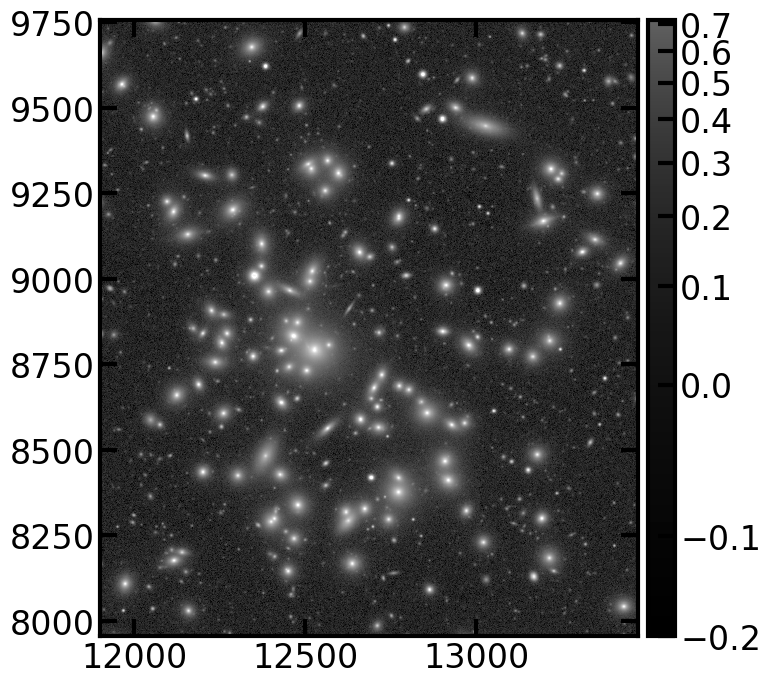

In [19]:
from lsst.afw.fits import MemFileManager
from lsst.afw.image import ExposureF
# PyVO packages
import pyvo
from pyvo.dal.adhoc import DatalinkResults, SodaQuery
# Astropy
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.io import fits
from astropy.wcs import WCS

def plotImage(exposure: ExposureF):
    """Plot and image using lsst.awf.image package

   Parameters
    ----------
    exposure : `ExposureF`
        the image to plot from file in LSST awf image exposure class format

   Returns
    -------
    image for notebook display
    """

    fig, ax = plt.subplots()
    display = afwDisplay.Display(frame=fig)
    display.scale('asinh', 'zscale')
    display.mtv(exposure.image)
    plt.show()




service = get_tap_service("tap")
spherePoint = geom.SpherePoint(my_ra_deg*geom.degrees, my_dec_deg*geom.degrees)

query = "SELECT access_format, access_url, dataproduct_subtype, " + \
    "lsst_patch, lsst_tract, lsst_band, s_ra, s_dec  " + \
    "FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
    "AND obs_collection = 'LSST.DP02' " + \
    "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
    "AND lsst_tract = " + str(my_tract) + " " + \
    "AND lsst_patch = " + str(my_patch) + " " + \
    "AND lsst_band = 'i' "

results = service.search(query)
results.to_table().show_in_notebook()

dataLinkUrl = results[0].getdataurl()

auth_session = service._session
dl_results = DatalinkResults.from_result_url(dataLinkUrl,
                                             session=auth_session)

f"Datalink status: {dl_results.status}. Datalink service url: {dataLinkUrl}"

sq = SodaQuery.from_resource(dl_results,
                             dl_results.get_adhocservice_by_id("cutout-sync"),
                             session=auth_session)

sphereRadius = 0.05 * u.deg

sq.circle = (spherePoint.getRa().asDegrees() * u.deg,
             spherePoint.getDec().asDegrees() * u.deg,
             sphereRadius)


cutout_bytes = sq.execute_stream().read()

mem = MemFileManager(len(cutout_bytes))
mem.setData(cutout_bytes, len(cutout_bytes))
exposure = ExposureF(mem)

plotImage(ExposureF(mem))
#or:
#fig, ax = plt.subplots()
#display = afwDisplay.Display(frame=fig)
#display.scale('asinh', 'zscale')
#display.mtv(exposure.image)
#plt.show()


## 7. Exercises for the learner

* a) Create `coadd` and `calexp` cutouts for the same RA, Dec, and band, and compare them side-by-side.
* b) Write your own function to create a cutout of a color image.

## 8. Additional Documentation

If you'd like some more information on `lsst.afw.display`, please have a look at the following websites:

* [Info on image indexing conventions.](https://pipelines.lsst.io/modules/lsst.afw.image/indexing-conventions.html)  
* [afw.display Doxygen website](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/namespacelsst_1_1afw_1_1display.html)  
* [afw.display GitHub website](https://github.com/RobertLuptonTheGood/afw/tree/master/python/lsst/afw/display)  
* [Getting Started on Image Display (pipelines.lsst.io)](https://pipelines.lsst.io/getting-started/display.html)